# Laser Power Analysis

In [1]:
#Import needed libraries
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import csv
import datetime
import os,platform
from scipy.optimize import curve_fit
import scipy
from scipy.fft import fft, rfft, irfft,ifft,fftfreq
from scipy.signal import argrelextrema
from scipy.stats import norm
from lmfit.models import SkewedGaussianModel


#varible for determining the lab pc or other pc, Check if windows or not, then try to grab pc name
pcname=""
if platform.system() == "Windows":
    pcname=platform.uname().node
else:
    try:
        pcname=os.uname()[1]
    except:
        print("Issue with finding pc name")

env_var_wavefromloc ="" #varible for location of waveform data. 
data_dir_mod_old="" #varible for small difference in storage managment between pc 1 and 2
if pcname=='PHYS-PSB02802': #Lab pc 2, (Labview pc)
    env_var_wavefromloc ="A:/DATA/waveforms/"
    env_var_waveformloc_old="C:/Users/KK_Lab28_1/Documents/Waveforms/"
    data_dir_mod_old=""

elif pcname=="PHYS-PSB02801": #Lab pc 1, (solidworks pc)
    env_var_wavefromloc ="data/waveforms/" #This is true for Jason's work atm (June 10th) Needs Updateing to global or user friendly verison
    data_dir_mod_old="/"
##############################

waveform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc


#Read in runlist and change cols to numbers
def ReadRunlist(filename="C:/Users/jasonbane/Desktop/nexo_code/Run Data (GUI v1)/RunList.csv"):
    return pd.read_csv(filename,index_col=False)

Runlist_DF = ReadRunlist()
Runlist_DF["RN"]=Runlist_DF["Run No."]
number_cols=["Anode V.","Anode Grid V.","Cathode V.","Cathode Grid V.","Drift Length"]
Runlist_DF[number_cols] = Runlist_DF[number_cols].apply(pd.to_numeric)

# Read in Drift stack measurment database for drift, ext, col lengths and errors
Distance_Database=pd.read_csv("C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/CellDistanceDataBase.csv")
Distance_Database["Date"] = Distance_Database["Date"].astype(str)
Distance_Database["Date"] = pd.to_datetime(Distance_Database["Date"])


# Add in distance to run list and calc fields
if 1==1:
#def runlist_distance_fix():
    global Runlist_DF
    global Distance_DataBase

    skip=0
    for i,run in enumerate(Runlist_DF["Run No."][skip:]):
        
        Date = pd.to_datetime(Runlist_DF["Date"].iloc[i+skip],format='%Y%m%d')
        # Date = datetime.datetime(Date)
        
        DF =Distance_Database[Distance_Database["Date"]<= Date].iloc[0]
        

        for key in DF.keys()[1:]:
            
            Runlist_DF.loc[i+skip,key] = DF[key]



Runlist_DF["Drift Field"] = (Runlist_DF["Cathode Grid V."] - Runlist_DF["Anode Grid V."])/(Runlist_DF["Drift Length"]/10.0)
Runlist_DF["Extraction Field"] = (Runlist_DF["Cathode V."] - Runlist_DF["Cathode Grid V."])/(Runlist_DF["Extraction Distance"]/10.0)
Runlist_DF["Collection Field"] = (Runlist_DF["Anode V."] - Runlist_DF["Anode Grid V."])/(Runlist_DF["Collection Distance"]/10.0)
Runlist_DF["Drift Distance"] = Runlist_DF["Drift Length"] + Runlist_DF["Extraction Distance"] + Runlist_DF["Collection Distance"]
Runlist_DF["Drift Distance Error"] = np.sqrt(Runlist_DF["Drift Length Error"]**2 + Runlist_DF["Collection Distance Error"]**2 + Runlist_DF["Extraction Distance Error"]**2)

#Bg database
bgdb=pd.read_csv("C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/bg_db.csv")


#make blank dataframe for background subtraction debugging
blankBG_DF= pd.DataFrame({"Avg Anode":[0]*50000})

In [2]:
# Gaussian function definition
def congaussian(x,A,t,sigma):
    return A * np.exp(-(x-t)/10)* np.exp(-(x-t)**2/(2*sigma**2))

def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))
def logarithmic_model(x, a, b):
    return a * np.log(b * x)

def dg(x,a,mu_a,sigma_a,m,b):
    return a * np.exp(-(x - mu_a) ** 2 / (2 * sigma_a ** 2)) +   (m + x*b)

def sin_linear(x, amplitude, frequency, phase, slope, intercept):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase) + slope * x + intercept
def sin(x, amplitude, frequency, phase ):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase)


# Define a sinusoidal function for fitting
def sinusoidal(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase) + offset


# Define the skewed Gaussian function
def skewed_gaussian(x, alpha, mu, sigma, amplitude):
    # Standard normal PDF
    pdf = amplitude * (2 / sigma) * norm.pdf((x - mu) / sigma)
    # Skew factor
    cdf = norm.cdf(alpha * (x - mu) / sigma)
    return pdf * cdf

def errfunc(x, a, b, z, f):
    return a * scipy.special.erf((x - z)*f) + b


# Define the Gaussian with a long tail function
def gaussian_with_tail(x, a, b, c, d):
    return np.where(
        x <= b,
        a * np.exp(-((x - b)**2) / (2 * c**2)),
        a * np.exp(-((x - b)**2) / (2 * c**2)) * np.exp(-d * (x - b))
    )

# Define the Gaussian with a long tail function
def congaussian_with_tail(x, a, b, c, d):
    return np.where(
        x <= b,
        congaussian(x,a,b,c),
        congaussian(x,a,b,c)* np.exp(-d * (x - b))
    )




#Function to retrieve run list information
def GetRunInfo(runnumber, old=False):
    global Runlist_DF
    if old:
        print("not set up yet")
        return -1
    
    DF=Runlist_DF.query('`Run No.`== %f'%(runnumber))

    if len(DF)==0:
        print("That run is not in the list")
        return 0
    else:
        return DF
    

def GetBGRun(run):
    global bgdb
    try:
        return bgdb.query("run==%i"%(run)).iloc[0]["background"]
    except:
        return -1

In [3]:
def GetWaveForm(runnumber,wavenumber=9):
    global waveform_path
    RI = GetRunInfo(runnumber) 
    if type(RI)==type(0): #Make sure run is in runlist
        return 0
    waveform_date ="%i"%(RI["Date"].iloc[0])
    runnumber="%05i"%(runnumber)

    # For left PC
    waveform_dir=waveform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="%s"%(wavenumber)

    waveform_filename=waveform_date+"-"+runnumber+"_"+"*"+waveform_wavenumber
    waveform_fullpath_wild=waveform_dir+"/"+waveform_filename+".csv"
    try: 
        waveform_fullpath=glob.glob(waveform_fullpath_wild )[-1].replace("\\","/")
    except:
        try:
            waveform_fullpath=glob.glob(waveform_dir+"/"+waveform_date+"-"+runnumber+"_"+"*" )[-1].replace("\\","/")
        except:
            print("issue with run")
            return 0
    
    if os.path.exists(waveform_fullpath):
        # Grab the second line and define the units of each column
        unit_line=open(waveform_fullpath).readlines()[1]
        units=unit_line.replace("(","").replace(")","").strip().split(",")
        #Build DF from csv
        DF=pd.read_csv(waveform_fullpath,skiprows=[1])
        
        # Convert to ms and mV
        for i,key in enumerate(DF.keys()):
            if units[i] == "V":
                
                DF[key]=DF[key]*1000 
            if units[i] == "ms":
                print("time convertion")
                DF[key]=DF[key]*1000 
        # rename columns
        #DF=ReNameCols(DF)
        return DF
    else: # Did not find file
        print("Issue with file")
        return 0
    

# this should correct the colomn names of the avg cath and anode. need to add incorrect options to list
def ReNameCols(DF):
    chann_name_options=[["Avg UV","Avg Anode"],
                        ['Average Cathode (2)', 'Average Anode (2)'],
                        ['average(Cathode)', 'average(Anode)']]
    Correct_names=["Avg Cathode","Avg Anode"]
    keys=DF.keys()
    if Correct_names[0] in keys and Correct_names[1] in keys:
        return DF
    for chan_options in chann_name_options:
        if chan_options[0] in keys:
            DF =DF.rename(columns={chan_options[0]: Correct_names[0]})
        if chan_options[1] in keys:
            DF =DF.rename(columns={chan_options[1]: Correct_names[1]})

    return DF






Runs 233 through 327

In [4]:
runlist = np.arange(233,328,1)

In [5]:
"Time","Channel Trigger","Channel UV"

('Time', 'Channel Trigger', 'Channel UV')

11.08949 700 145.99999343
[1.05350155e+01 1.53299993e+02 7.87383981e+01 8.50329014e-14]
[[1.55100957e-02 2.88421218e-01 1.39684309e-01 9.30431368e-05]
 [2.88421218e-01 7.98590585e+00 4.31124862e+00 2.46511145e-03]
 [1.39684309e-01 4.31124862e+00 2.77674533e+00 1.39078567e-03]
 [9.30431368e-05 2.46511145e-03 1.39078567e-03 7.95231724e-07]]


Text(0.5, 0, 'Time [ns]')

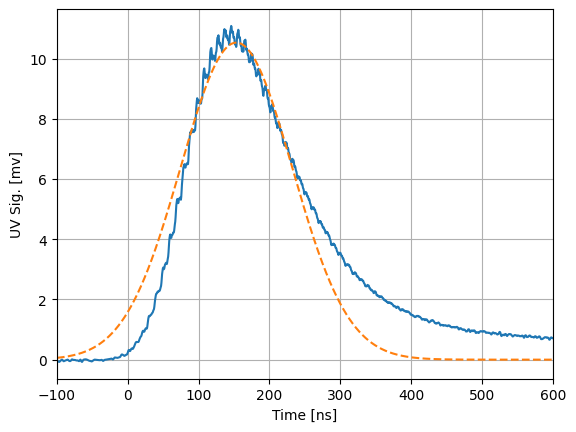

In [6]:
rn = 233


DF=GetWaveForm(249)


max=np.max(DF["Avg UV"])
max_loc = np.where(DF["Avg UV"]==max)[0][0]
max_time=DF["Time"].iloc[max_loc]
print(max,max_loc,max_time)


plt.errorbar(DF["Time"],DF["Avg UV"])


fitdata_x= DF["Time"]
fitdata_y= DF["Avg UV"]

p0_gwt=[max,max_time,10,2]
range_gwt=[[max*0.95,max_time*0.95,0,0],[max*1.05,max_time*1.05,2000,10]]
ppot,pcov = curve_fit(gaussian_with_tail,fitdata_x,fitdata_y,p0=p0_gwt, bounds=range_gwt)



print(ppot)
print(pcov)

fitx=np.arange(-100,max_time*4.95,0.01)
fity=gaussian_with_tail(fitx, *ppot)

plt.errorbar(fitx,fity, fmt ="--",label="Fit")

plt.grid()
plt.xlim(-100,600)
plt.ylabel("UV Sig. [mv]")
plt.xlabel("Time [ns]")

In [7]:
np.where(np.array([0,1,2,3,4,5])<=2,1,2)

array([1, 1, 1, 2, 2, 2])

C:\Users\jasonbane\AppData\Local\Temp\ipykernel_19064\2775865607.py:19: RuntimeWarning: invalid value encountered in log
  a * np.exp(-((x - b)**2) / (2 * c**2)) * np.log(1 + d * (x - b))


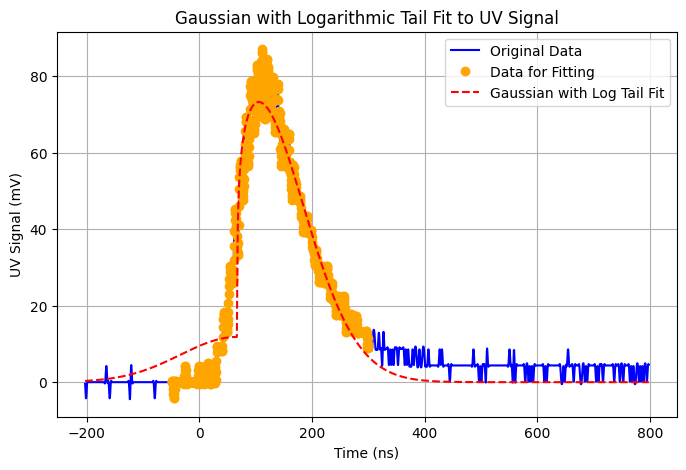

Amplitude: 11.823814289082678
Mean: 66.73062958974901
Standard Deviation: 100.28003327687556
Logarithmic Tail Decay Constant: 20.391498039103073


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


runnumber=285

# Load your dataset
data = pd.read_csv("C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028\osci\data\waveforms/20241030/20241030-00%i/20241030-00%i_10.csv"%(runnumber,runnumber),skiprows=[1,2])  # Replace with your file path
time = data["Time"].astype(float).values
uv_signal = data["Channel UV"].astype(float).values

# Define the Gaussian with a logarithmic tail function
def gaussian_with_log_tail(x, a, b, c, d):
    return np.where(
        x <= b,
        a * np.exp(-((x - b)**2) / (2 * c**2)),
        a * np.exp(-((x - b)**2) / (2 * c**2)) * np.log(1 + d * (x - b))
    )

# Initial guesses for the parameters [amplitude, mean, std_dev, tail_decay]
initial_guess = [200, 100, 50, 0.01]

# Define the fitting range (adjust t_min and t_max as needed)
t_min = -50
t_max = 300
fit_mask = (time >= t_min) & (time <= t_max)
time_fit = time[fit_mask]
uv_signal_fit = uv_signal[fit_mask]

# Perform the curve fitting
popt, pcov = curve_fit(gaussian_with_log_tail, time_fit, uv_signal_fit, p0=initial_guess)

# Extract the parameters
amplitude, mean, std_dev, log_tail_decay = popt

# Generate the fitted curve for the full time range
fitted_uv_signal = gaussian_with_log_tail(time, *popt)

# Plot the data and the fitted curve
plt.figure(figsize=(8, 5))
plt.plot(time, uv_signal, label="Original Data", color="blue")
plt.plot(time_fit, uv_signal_fit, 'o', label="Data for Fitting", color="orange")
plt.plot(time, fitted_uv_signal, label="Gaussian with Log Tail Fit", color="red", linestyle="--")
plt.xlabel("Time (ns)")
plt.ylabel("UV Signal (mV)")
plt.title("Gaussian with Logarithmic Tail Fit to UV Signal")
plt.legend()
plt.grid()
plt.show()

# Print the parameters
print(f"Amplitude: {amplitude}")
print(f"Mean: {mean}")
print(f"Standard Deviation: {std_dev}")
print(f"Logarithmic Tail Decay Constant: {log_tail_decay}")


In [9]:
# Define the skewed Gaussian function
def skewed_gaussian(x, a, b,bb, c, alpha):
    return a * np.exp(-((x - b)**2) / (2 * c**2)) * (1 + erf(alpha * (x - bb) / np.sqrt(2)))

99.62475 611 101.49999469
72.16388708813315 10.149999469057109 70.90246530648082 115.40003126539763 0.038620920165828874
[ 3.00768247e-01 -3.18095835e+07  1.56815858e+04]


c:\Python310\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
c:\Python310\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_19064\1652202015.py:115: RuntimeWarning: invalid value encountered in log
  log_tail = np.log(1 + alpha * (x - mu))


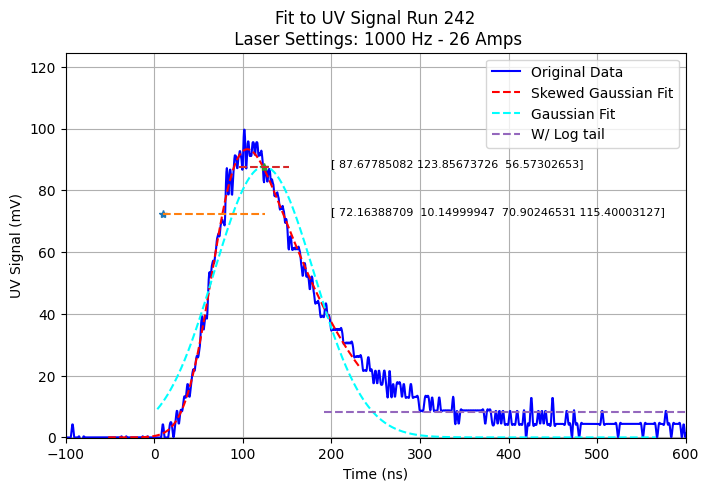

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.optimize import minimize

# Load your dataset

#runnumber=309 #max
#runnumber=278 #middle ??
#runnumber=251 #min

runnumber=242
stepsize=2
RI = GetRunInfo(runnumber)

# Load your dataset
data = GetWaveForm(runnumber)#pd.read_csv("C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028\osci\data\waveforms/20241030/20241030-00%i/20241030-00%i_10.csv"%(runnumber,runnumber),skiprows=[1,2])  # Replace with your file path

time = data["Time"].astype(float).values
uv_signal = data["Channel UV"].astype(float).values

max= np.max(uv_signal)
max_loc = np.where(uv_signal==max)[0][0]
max_time=time[max_loc]
print(max,max_loc,max_time)
edge_h= max*0.25


second_edge= int(np.ceil(np.average(np.where(np.abs(uv_signal[max_loc:] -edge_h) <= max*0.025)))+max_loc)
first_edge = int(np.floor(np.average(np.where(np.abs(uv_signal[:max_loc] -edge_h) <= max*0.02))))



second_edge_time=time[second_edge]

#begin=200
begin=first_edge-200
end=second_edge

fitting_time = data["Time"][int(np.floor(begin)):int(np.ceil(end)):stepsize].astype(float).values
fitting_uv_signal = data["Channel UV"][int(np.floor(begin)):int(np.ceil(end)):stepsize].astype(float).values



# Initial guesses for the parameters [amplitude, mean, std_dev, skewness]
initial_guess = [max, max_time,max_time, 50, 0.5]
bounds=[[max*0.05,max_time*0.1,max_time*0.1,0,0],[max*1.5,max_time*1.5,max_time*3.5,500,500]]
# Fit the curve
popt, pcov = curve_fit(skewed_gaussian, fitting_time, fitting_uv_signal, p0=initial_guess,bounds=bounds)

print(*popt)

# Extract the parameters
amplitude, mean,meanprime,std_dev, skewness = popt

# Generate the fitted curve
fitted_uv_signal = skewed_gaussian(fitting_time, *popt)

# Plot the data and the fitted curve
plt.figure(figsize=(8, 5))
plt.plot(time, uv_signal,label="Original Data", color="blue")
plt.plot(fitting_time, fitted_uv_signal, label="Skewed Gaussian Fit", color="red", linestyle="--")


plt.plot(mean,amplitude, marker="*")
plt.errorbar([mean,mean+std_dev],[amplitude,amplitude],fmt="--")




plt.text(200,amplitude,popt[:4],size=8)

plt.xlabel("Time (ns)")
plt.ylabel("UV Signal (mV)")
plt.title("Fit to UV Signal Run %i\n Laser Settings: %s Hz - %s Amps"%(runnumber,RI["Laser Freq."].iloc[0],RI["Laser Current"].iloc[0]))


edge_h= max*0.05
second_edge= int(np.floor(np.average(np.where(np.abs(uv_signal[max_loc:] -edge_h) <= max*0.03)))+max_loc)
first_edge = int(np.floor(np.average(np.where(np.abs(uv_signal[:max_loc] -edge_h) <= max*0.03))))

#begin=200
begin=first_edge
end=second_edge
fitting_time = data["Time"][int(np.floor(begin)):int(np.ceil(end)):stepsize].astype(float).values
fitting_uv_signal = data["Channel UV"][int(np.floor(begin)):int(np.ceil(end)):stepsize].astype(float).values



# Initial guesses for the parameters [amplitude, mean, std_dev, skewness]
initial_guess = [max, max_time, 50]

# Fit the curve
popt, pcov = curve_fit(gaussian, fitting_time, fitting_uv_signal, p0=initial_guess)

# Generate the fitted curve
fitted_uv_signal = gaussian(fitting_time, *popt)
plt.plot(fitting_time, fitted_uv_signal, label="Gaussian Fit", color="Cyan", linestyle="--")

# Extract the parameters
amplitude, mean, std_dev = popt

plt.plot(mean,amplitude, marker="*")
plt.errorbar([mean-std_dev/2,mean+std_dev/2],[amplitude,amplitude],fmt="--")

plt.text(200,amplitude,popt,size=8)



# Define the Gaussian with logarithmic tail function
def gaussian_with_log_tail(x, A, mu, alpha):
    
    log_tail = np.log(1 + alpha * (x - mu))
    return  A * log_tail





edge_h= max*0.4
first_edge = int(np.floor(np.average(np.where(np.abs(uv_signal[max_loc:] -edge_h) <= max*0.03)))+max_loc)


#begin=200
begin=first_edge
end = len(time)
fitting_time = data["Time"][int(np.floor(begin)):int(np.ceil(end)):stepsize].astype(float).values
fitting_uv_signal = data["Channel UV"][int(np.floor(begin)):int(np.ceil(end)):stepsize].astype(float).values
# Fit the curve


popt, pcov = curve_fit(gaussian_with_log_tail, fitting_time, fitting_uv_signal)

# Generate the fitted curve
fitted_uv_signal = gaussian_with_log_tail(fitting_time, *popt)
plt.plot(fitting_time, fitted_uv_signal, label="W/ Log tail",  linestyle="--")

print(popt)



plt.ylim(-0.1,max*1.25)

plt.xlim(-100,600)
plt.legend()

plt.grid()



In [11]:
from ipywidgets import interact
from ipywidgets import FloatSlider,Layout,IntSlider

In [283]:



# Define the Gaussian with logarithmic tail function
def gaussian_with_log_tail(x, A, mu, alpha):
    log_tail = np.log(1 + alpha * (x - mu))
    return  A * log_tail




def logtailgraph(A,alpha,mu):


    x=np.arange(150,500,1)
    y=gaussian_with_log_tail(x,A,mu,alpha)

    plt.plot(x,y,label="Log tail")


C:\Users\jasonbane\AppData\Local\Temp\ipykernel_19068\3900087115.py:113: RuntimeWarning: divide by zero encountered in log
  log_tail = np.log(1 + alpha * (x - mu))
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_19068\3900087115.py:113: RuntimeWarning: invalid value encountered in log
  log_tail = np.log(1 + alpha * (x - mu))
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_19068\3900087115.py:114: RuntimeWarning: divide by zero encountered in divide
  return  A /log_tail


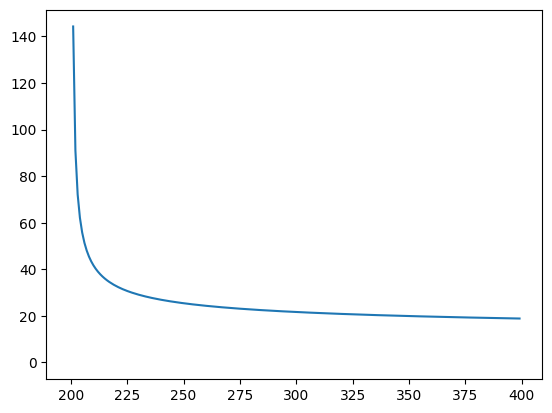

In [27]:
x= np.arange(150,400,1)
y = gaussian_with_log_tail(x, 100,200,1)
plt.plot(x,y)



In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.optimize import minimize

# Load your dataset
max_value=[]
fitted_max=[]
avg_max=[]
max_std=[]
max_width=[]
laser_freq=[]
laser_cur=[]
#runnumber=309 #max
runnumber=278 #middle ??
#runnumber=251 #min
stepsize=1

for runnumber in runlist:
    print(runnumber)

    RI = GetRunInfo(runnumber)

    # Load your dataset
    data = GetWaveForm(runnumber)
    if type(RI) == type(0):
        continue
    time = data["Time"][::stepsize].astype(float).values
    uv_signal = data["Channel UV"][::stepsize].astype(float).values

    max= np.max(uv_signal)
    max_loc = np.where(uv_signal==max)[0][0]
    max_time=time[max_loc]
   #print(max,max_loc,max_time)
    edge_h= max*0.25
    try:
        second_edge= int(np.ceil(np.average(np.where(np.abs(uv_signal[max_loc:] -edge_h) <= max*0.05)))+max_loc)
        first_edge = int(np.floor(np.average(np.where(np.abs(uv_signal[:max_loc] -edge_h) <= max*0.05))))
    except:
        print("Issue with run", runnumber)
        continue

    begin=first_edge-200
    end=second_edge

    fitting_time = time[begin:end]
    fitting_uv_signal = uv_signal[int(np.floor(begin)):int(np.ceil(end))]


    # Initial guesses for the parameters [amplitude, mean, std_dev, skewness]
    initial_guess = [max, max_time,max_time, 50, 0.5]
    bounds=[[max*0.05,max_time*0.1,max_time*0.1,0,0],[max*1.5,max_time*1.5,max_time*3.5,500,500]]
    # Fit the curve
    popt, pcov = curve_fit(skewed_gaussian, fitting_time, fitting_uv_signal, p0=initial_guess,bounds=bounds)

    
    # Extract the parameters
    amplitude, mean,meanprime,std_dev, skewness = popt

    # Generate the fitted curve
    fitted_uv_signal = skewed_gaussian(fitting_time, *popt)

    fitted_max.append(np.max(fitted_uv_signal))




    edge_h= max*0.95
    try:
        second_edge= int(np.ceil(np.average(np.where(np.abs(uv_signal[max_loc:] -edge_h) <= max*0.05)))+max_loc)
        first_edge = int(np.floor(np.average(np.where(np.abs(uv_signal[:max_loc] -edge_h) <= max*0.05))))
    except:
        print("Issue with run", runnumber)
        continue

  

    begin=first_edge
    end=second_edge

    fitting_time = time[begin:end]
    fitting_uv_signal = uv_signal[int(np.floor(begin)):int(np.ceil(end))]
    average_top = np.average(fitting_uv_signal)
    average_stddev=np.std(fitting_uv_signal)

    max_value.append(max)
    avg_max.append(average_top)
    max_std.append(average_stddev)
    
    max_width.append(fitting_time[-1] - fitting_time[0])
    laser_freq.append(float(RI["Laser Freq."].iloc[0]))
    laser_cur.append(float(RI["Laser Current"].iloc[0]))
    




233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327


In [15]:
laser_power_info={}
laser_power_info["run"]=runlist
laser_power_info["current"]=laser_cur
laser_power_info["freq"]=laser_freq
laser_power_info["max value"]=max_value
laser_power_info["max avg"]=avg_max
laser_power_info["max std"]=max_std
laser_power_info["max width"]=max_width
laser_power_info["fitted max"]=fitted_max

In [16]:
laserpower_DF = pd.DataFrame.from_dict(laser_power_info)
laserpower_DF

,run,current,freq,max value,max avg,max std,max width,fitted max
0,233,26.0,100.0,231.760600,215.579464,8.071038,12.000000,216.325163
1,234,26.0,200.0,218.903800,210.137326,6.099576,16.500000,211.420401
2,235,26.0,300.0,208.599900,199.976039,5.569193,16.000000,200.557558
3,236,26.0,400.0,201.694700,192.608056,5.196241,16.500000,194.755505
4,237,26.0,500.0,184.670300,176.571900,6.093193,16.500000,177.357544
...,...,...,...,...,...,...,...,...
90,323,28.0,1500.0,130.930100,127.356486,2.417278,20.499999,128.023578
91,324,28.0,2000.0,73.314460,69.173113,2.304884,18.999999,69.526320
92,325,28.0,2500.0,37.470780,34.920066,1.376981,22.999999,35.240845
93,326,28.0,3000.0,23.502090,21.808485,1.137975,23.499999,21.754148


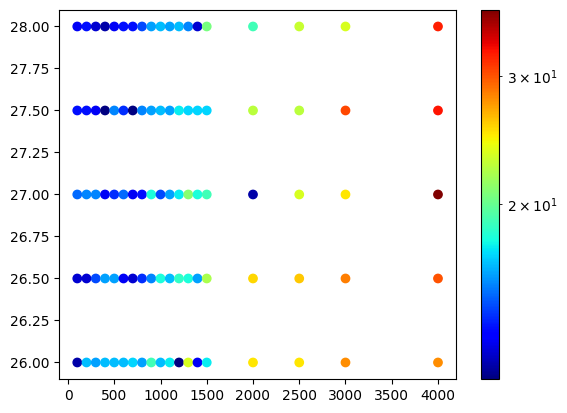

In [17]:
from matplotlib.colors import LogNorm
plt.scatter(x=laserpower_DF["freq"],y=laserpower_DF["current"],c=laserpower_DF["max width"],cmap="jet",norm=LogNorm())



plt.colorbar()


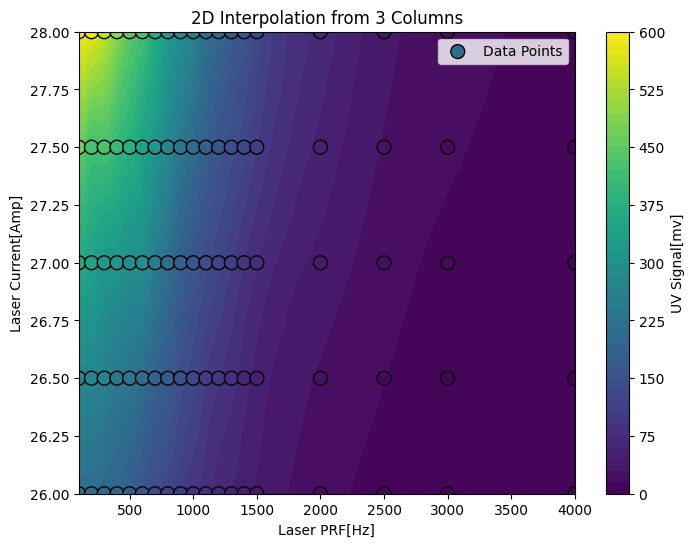

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib

df= laserpower_DF
df["y"]=df["current"]
df["x"]=df["freq"]
df["value"]=df["fitted max"]


# Define the grid for interpolation
grid_x, grid_y = np.linspace(df["x"].min(), df["x"].max(), 100), np.linspace(df["y"].min(), df["y"].max(), 100)
grid_x, grid_y = np.meshgrid(grid_x, grid_y)

# Perform interpolation
grid_z = griddata(
    points=(df["x"], df["y"]),  # Known data points
    values=df["value"],         # Values at those points
    xi=(grid_x, grid_y),        # Points where interpolation is computed
    method="cubic"             # Interpolation method ('linear', 'nearest', 'cubic')
)

# Plot the interpolated 2D heatmap
plt.figure(figsize=(8, 6))
plt.contourf(grid_x, grid_y, grid_z, levels=50, cmap="viridis")
plt.colorbar(label="UV Signal[mv]")

# Scatter the original points
plt.scatter(df["x"], df["y"], c=df["value"], cmap="viridis", edgecolor="k", s=100, label="Data Points")

# Add labels and title
plt.title("2D Interpolation from 3 Columns")
plt.xlabel("Laser PRF[Hz]")
plt.ylabel("Laser Current[Amp]")
plt.legend()
plt.show()


In [24]:
griddata(
    points=(df["x"], df["y"]),  # Known data points
    values=df["value"],         # Values at those points
    xi=([1750,1600],[27.27,26.2] ),        # Points where interpolation is computed
    method="cubic"             # Interpolation method ('linear', 'nearest', 'cubic')
)

array([64.20373613, 40.37914869])

In [25]:
df.to_csv("LaserPower_data.csv",index=False)

In [26]:
def LaserPowermv(cur=[26],freq=[101],method="linear"):
    ## Grabs a table of laswer power data and gives you the estimate max mv signal through inerploation via the griddata function with the method linear or cubic

    df=pd.read_csv("LaserPower_data.csv")

    # Perform interpolation
    power= griddata(
        points=(df["freq"], df["current"]),  # Known data points
        values=df["fitted max"],         # Values at those points
        xi=(freq, cur),        # Points where interpolation is computed
        method=method             # Interpolation method ('linear', 'nearest', 'cubic')
    )
    if power  != power:
        print("Outside of range try again")
        return 0 

    return power



In [30]:
LaserPowermv([28.0],[100])

array([591.65874888])